In [30]:
import nltk
from nltk.tokenize import WhitespaceTokenizer
from string import punctuation
import re
import string
import random

%matplotlib inline
import os
from lxml import etree
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

from __future__ import print_function

import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import pymorphy2
import gensim
from sklearn.preprocessing import MinMaxScaler

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

In [31]:
def take_text(fin):
    f = open(fin, 'r', encoding = 'utf-8')
    twi = []
    cont = []
    l = f.readlines()
    for i in l:
        i = i.replace('"\n', '')
        if i[0] == '"':
            lst = i[1:].split('";"')
        else:
            lst = i.split('";"')
        if len(lst) == 12:
            twi.append(lst)
        elif cont == []:
            cont += lst
        elif '\n' in cont[-1] and lst != []:
            c = cont[-1]
            cont = cont[:-1]
            cont.append(c+lst[0])
            cont += lst[1:]
            if len(cont) == 12:
                twi.append(cont)
                cont = []
    f.close()
    
    only_twits = []
    for line in twi:
        only_twits.append(line[3])
    
    return only_twits

In [32]:
def spacing(text):
    spaces = re.findall('[^\\w]((?:\\w ){3,}\\w)[ '+string.punctuation+'—–…“”«»'+']',text)
    for elem in spaces:
        text = text.replace(elem,elem.replace(' ',''))
    return text

In [33]:
def normalize(l):
    l = re.sub(r"((https?:\/\/|www)|\w+\.(\w{2-3}))([\w\!#$&-;=\?\-\[\]~]|%[0-9a-fA-F]{2})+", '', l) #убираем ссылки
    l = re.sub(r"(?:@\w+)", '', l)                                        # убираем пользователя
    l = re.sub(r"[\w.+-]+@[\w-]+\.(?:[\w-]\.?)+[\w-]", '', l)             # убираем email
    l = re.sub(r"(?:I'm at .*? in .*?(?: w/ @[\w])?|\(@ .*?\))", '', l)   # убираем геолокации
    l = l.replace('RT', '')                                              # убираем RT    
    exclude = set(punctuation + '0123456789'+u'–—'+u'«»')
    l = ''.join(ch for ch in l if ch not in exclude)
    lower_up = [m.start() for m in re.finditer(r"[a-zа-яё]{1}[A-ZА-ЯЁ]{1}", l)]   # добавляем пробел между lower- и uppercase HiWorld => Hi World 
    for i in reversed(lower_up):
        l = l[:i+1] + ' ' + l[i+1:]
    l = re.sub(u'(\w)\\1{2,}', u'\\1\\1', l)   # буквы больше двух раз подряд
    l = spacing(l)                                # р а з р я д к а
    l = l.lower()                                                         # уменьшаем регистр у всех букв  
    return l

In [34]:
def norm_tw(twits):
    norm_twits = []
    for i in range(len(twits)):
        norm_twits.append(normalize(twits[i]))
    return norm_twits

In [35]:
twits = take_text('positive.csv')
neg_twits = take_text('negative.csv')

In [36]:
twits = random.sample(twits, len(twits)//10)
neg_twits = random.sample(neg_twits, len(neg_twits)//10)

In [38]:
from collections import Counter
import re
import string
import pandas as pd
import time

class Profiler(object):
    def __enter__(self):
        self._startTime = time.time()

    def __exit__(self, type, value, traceback):
        print ("Elapsed time: {:.3f} sec".format(time.time() - self._startTime))

def spacing(text):
    spaces = re.findall('[^\\w]((?:\\w ){3,}\\w)[ '+string.punctuation+'—–…“”«»'+']',text)
    for elem in spaces:
        text = text.replace(elem,elem.replace(' ',''))
    return text


def word_counter(text, mystopwords):
    '''
    Считаем слова
    :param text:
    :return:
    '''
    text = text.split()
    text_wo_sw = [i for i in text if i.lower() not in mystopwords]
    return{'len' : len(text_wo_sw)}


def punct_counter(text):
    punct = re.findall('[!?]', text)
    c = Counter(punct)
    c_punct = {'excl': c['!'], 'quest': c['?']}
    return c_punct

def emoji_counter(text):
    '''
    Считает емодзи
    :param emoji:
    :return:
    '''
    with open ('em_neg.txt', 'r', encoding='utf-8') as em_neg:
        neg_emoji = [line.strip() for line in em_neg]
        ne = '[' + '|'.join(neg_emoji) + ']'
    emoji_n = re.findall(ne, text)
    with open('em_neg.txt', 'r', encoding='utf-8') as em_pos:
        pos_emoji = [line.strip() for line in em_pos]
        pe = '[' + '|'.join(pos_emoji) + ']'
    emoji_p = re.findall(pe, text)
    c_em = {'pos_em': sum(Counter(emoji_p).values()), 'neg_em': sum(Counter(emoji_n).values())}
    return c_em

def smile_counter(text):
    '''
    Считает смайлики
    :param smiles:
    :return:
    '''
    sm_n = re.findall(r'(:\(|;\(|=\(|:-\()', text)
    sm_p = re.findall(r'(:\)|:D|: @|;\)|:-\)|=\)|:\*|:3)', text)
    c_smiles = {'pos_sm' : sum(Counter(sm_p).values()), 'neg_sm' : sum(Counter(sm_n).values())}
    return c_smiles

def ahah_counter(text):
    '''
    Считает смешки
    '''
    ahah = re.findall(r'', text)
    ahah = [len(i) for i in ahah]
    c_ahah = {'haha' : sum(ahah)}
    return c_ahah


def normalize(l):
    l = re.sub(r"((https?:\/\/|www)|\w+\.(\w{2,3}))([\w\!#$&-;=\?\-\[\]~]|%[0-9a-fA-F]{2})+", '', l) #убираем ссылки
    l = re.sub(r"(?:@\w+)", '', l)                                        # убираем пользователя
    l = re.sub(r"[\w.+-]+@[\w-]+\.(?:[\w-]\.?)+[\w-]", '', l)             # убираем email
    l = re.sub(r"(?:I'm at .*? in .*?(?: w/ @[\w])?|\(@ .*?\))", '', l)   # убираем геолокации
    l = l.replace('RT', '')                                              # убираем RT
    exclude = string.punctuation + '0123456789' + u'—' + u'«»'
    regex = re.compile('[%s]' % re.escape(exclude))
    l = regex.sub(' ', l)
    lower_up = [m.start() for m in re.finditer(r"[a-zа-яё]{1}[A-ZА-ЯЁ]{1}", l)]   # добавляем пробел между lower- и uppercase HiWorld => Hi World
    for i in reversed(lower_up):
        l = l[:i+1] + ' ' + l[i+1:]
    l = re.sub(u'(\w)\\1{2,}', u'\\1\\1', l)   # буквы больше двух раз подряд
    l = spacing(l)                                # р а з р я д к а
    l = l.lower()                                                         # уменьшаем регистр у всех букв
    return l

def merge_dicts(*dict_args):
    """
    Given any number of dicts, shallow copy and merge into a new dict,
    precedence goes to key value pairs in latter dicts.
    """
    result = {}
    for dictionary in dict_args:
        result.update(dictionary)
    return result


def twit_to_data(text, twits_data, mystopwords):
    '''
    Превращает твит в строку датафайла
    '''
    punct = punct_counter(text)
    smile = smile_counter(text)
    text_n = normalize(text)
    words = word_counter(text_n, mystopwords)
    ahah = ahah_counter(text)
    md = merge_dicts(punct, ahah, smile, words)
    twits_data.append(md)


In [39]:
from pymystem3 import Mystem  # импортируем майстем
from nltk.corpus import stopwords
import time

mystopwords = stopwords.words('russian') + [u'это', u'иза', u'свой', u'млрд', u'млн', u'млна', u'тыс', u'трлн', u'x', u'd', u'х', u'д', u'з',  u'р',  u'p']

twits_data_n = []
twits_data_p = []
start_time = time.time()
for i in range(len(twits)):
    twit_to_data(twits[i], twits_data_p, mystopwords)
    if i % 100 == 0:
        print("--- %s seconds ---" % (time.time() - start_time))
        print('%s из %s' % (i, len(twits)))
for i in range(len(neg_twits)):
    twit_to_data(neg_twits[i], twits_data_n, mystopwords)
    if i % 100 == 0:
        print("--- %s seconds ---" % (time.time() - start_time))
        print('%s из %s' % (i, len(twits)))
df_p = pd.DataFrame(twits_data_p)
df_n = pd.DataFrame(twits_data_n)

--- 0.0004999637603759766 seconds ---
0 из 9807
--- 0.024014949798583984 seconds ---
100 из 9807
--- 0.051032066345214844 seconds ---
200 из 9807
--- 0.0735476016998291 seconds ---
300 из 9807
--- 0.09406137466430664 seconds ---
400 из 9807
--- 0.12308120727539062 seconds ---
500 из 9807
--- 0.15560245513916016 seconds ---
600 из 9807
--- 0.18462181091308594 seconds ---
700 из 9807
--- 0.2141413688659668 seconds ---
800 из 9807
--- 0.24065899848937988 seconds ---
900 из 9807
--- 0.2596714496612549 seconds ---
1000 из 9807
--- 0.2781836986541748 seconds ---
1100 из 9807
--- 0.30070018768310547 seconds ---
1200 из 9807
--- 0.33672285079956055 seconds ---
1300 из 9807
--- 0.35623598098754883 seconds ---
1400 из 9807
--- 0.37674927711486816 seconds ---
1500 из 9807
--- 0.397763729095459 seconds ---
1600 из 9807
--- 0.42027831077575684 seconds ---
1700 из 9807
--- 0.43929076194763184 seconds ---
1800 из 9807
--- 0.4573028087615967 seconds ---
1900 из 9807
--- 0.4788188934326172 seconds ---


In [41]:
norm_twits = norm_tw(twits)
neg_norm_twits = norm_tw(neg_twits)

In [42]:
from gensim.models.keyedvectors import KeyedVectors

m = 'C:/Users/Вереск/Anaconda3/Lib/site-packages/gensim/models/ruwikiruscorpora_0_300_20.bin.gz'
model = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format(m, binary=True)

In [43]:
morph = pymorphy2.MorphAnalyzer()
def normalize_and_add_pos(word):
    p = morph.parse(word)[0]
    pos = p.tag.POS
    if pos:
        if 'ADJ' in pos:
            pos = 'ADJ'
    else:
        pos = ''
    return '{}_{}'.format(
        p.normal_form,
        pos
    )

In [44]:
def with_features(twits, clas, df):
    data = []
    for i in range(len(twits)):
        text_vectors = []
        words = twits[i].split()
        for word in words:
            norm_word = normalize_and_add_pos(word)
            if norm_word in model:
                text_vectors.append(model[norm_word])
        if len(text_vectors) != 0:
            mean_vector = sum(text_vectors) / len(text_vectors)
            formal_features = []
            pos = twits[i].count(')')
            neg = twits[i].count('(')
            excl = df.at[i,'excl']
            quest = df.at[i,'quest']
            lenght = df.at[i,'len']
            ahah = df.at[i, 'haha']
            formal_features.append(float(pos))
            formal_features.append(float(neg))
            formal_features.append(float(excl))
            formal_features.append(float(quest))
            formal_features.append(float(lenght))
            formal_features.append(float(ahah))
            data.append(list(mean_vector)+formal_features)
    df = pd.DataFrame.from_dict({'text':data})
    df['class'] = clas
    return df

In [45]:
data1 = with_features(twits, 1, df_p)

In [46]:
data2 = with_features(neg_twits, 0, df_n)

In [47]:
data = pd.concat([data1, data2])
data = data.sample(frac=1).reset_index(drop=True)

In [48]:
data.head()

,text,class
0,"[-0.0286135, 0.0334908, -0.0362594, -0.0082450...",0
1,"[0.0606687, 0.0352509, 0.00103703, 0.0274607, ...",0
2,"[-0.0241237, 0.0571631, 0.0189541, -0.0070501,...",0
3,"[-0.0577944, -0.0216278, -0.00773383, 0.009516...",1
4,"[-0.0352824, 0.0188451, -0.0115369, -0.0176661...",1


In [49]:
X_train, X_test, y_train, y_test = train_test_split(list(data['text']), list(data['class']), test_size=0.3)

In [50]:
min_max_scaler = MinMaxScaler()
X_train_norm = min_max_scaler.fit_transform(X_train)
X_test_norm = min_max_scaler.fit_transform(X_test)

In [51]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time.time()
    if clf == MultinomialNB(alpha=.01):
        clf.fit(X_train, y_train)
    else:
        clf.fit(X_train_norm, y_train)
#     train_time = time() - t0
#     print("train time: %0.3fs" % train_time)

    t0 = time
    if clf == MultinomialNB(alpha=.01):
        pred = clf.predict(X_test)
    else:
        pred = clf.predict(X_test_norm)
        
#     test_time = time() - t0
#     print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    print()
    clf_descr = str(clf).split('(')[0]
    if "penalty" in vars(clf):
        return clf_descr+' '+str(clf.penalty), score
    else:
        return clf_descr, score

results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
#        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='l2', penalty=penalty,
                                            dual=False, tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train Logistic Regression
print('=' * 80)
print("Logistic Regression")
results.append(benchmark(LogisticRegression()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC( penalty="l1", dual=False, tol=1e-3))),
  ('classification', LinearSVC())
])))

# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(2)]

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
accuracy:   0.904

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=50, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)
accuracy:   0.720

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, class_weight=None, fit_intercept=True,
              loss='hinge', n_iter=50, n_jobs=1, random_state=None,
              shuffle=True, verbose=0, warm_start=False)
accuracy:   0.944

Random forest
________________________________________________________

C:\Users\Вереск\Anaconda3\lib\site-packages\sklearn\svm\classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


accuracy:   0.957

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
accuracy:   0.889

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='l2', max_iter=1000, multi_class='ovr',
     penalty='l1', random_state=None, tol=0.001, verbose=0)


C:\Users\Вереск\Anaconda3\lib\site-packages\sklearn\svm\classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


accuracy:   0.974

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l1', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
accuracy:   0.975

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
accuracy:   0.907

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
Near

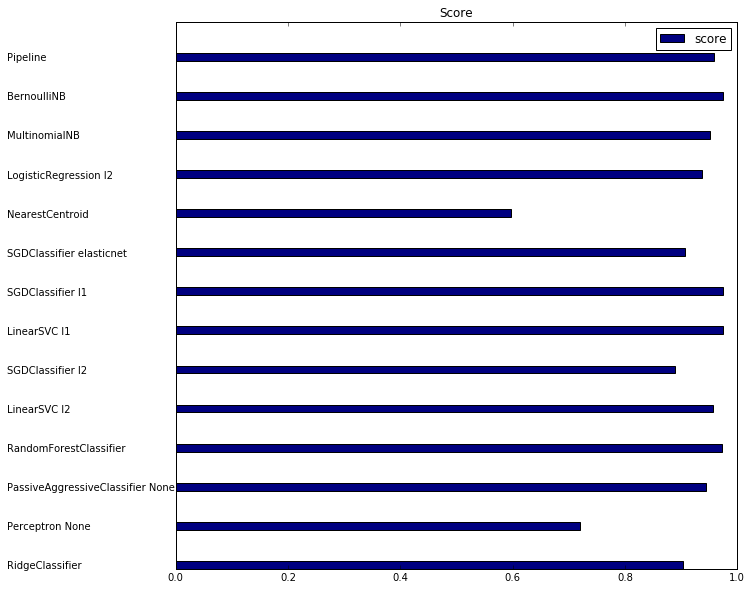

In [52]:
# визуализация

scores = results[1]
cls_names = results[0]

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, scores, .2, label="score", color='navy')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=1)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, results[0]):
    plt.text(-.3, i, c)
plt.show()